# Distance metric comparison
> Do the pairwise distances between mixture embeddings correlate with things like beta-diversity?

In [23]:
%load_ext autoreload
%autoreload 2

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import anndata

# Clustering must allow custom distance metric
import scipy
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances

from skbio import TreeNode
from skbio.diversity import beta_diversity
from skbio.diversity.beta import unweighted_unifrac, weighted_unifrac

from tqdm.notebook import tqdm

from geomstats.geometry.hyperbolic import Hyperbolic

from joblib import Parallel, delayed

# from util import mixture_embedding

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
N_SAMPLES = 100


In [25]:
# Load data
adata = anndata.read_h5ad(
    # "/home/phil/americangut/data/americangut_embeddings.h5ad"
    "/home/phil/americangut/data/big_table_with_embeddings.h5ad"
)
adata

# Add counts to big_table
if "counts" not in adata.obs.columns:
    adata_raw = anndata.read_h5ad(
        "/home/phil/americangut/data/americangut_raw.h5ad"
    )
    counts = adata_raw.X.sum(axis=1).astype(int)
    adata.obs["counts"] = counts

# Downsample to some number of samples to make things tractable:
np.random.seed(42)
sample_idx = np.random.choice(
    np.arange(adata.shape[0]), size=N_SAMPLES, replace=False
)
adata = adata[sample_idx, :].copy()
adata

# Drop OTUs that are all zeros
adata = adata[:, adata.X.sum(axis=0) > 0].copy()
adata


AnnData object with n_obs × n_vars = 100 × 4989
    obs: 'acid_reflux', 'acne_medication', 'acne_medication_otc', 'add_adhd', 'age_cat', 'age_years', 'alcohol_consumption', 'alcohol_frequency', 'alcohol_types_beercider', 'alcohol_types_red_wine', 'alcohol_types_sour_beers', 'alcohol_types_spiritshard_alcohol', 'alcohol_types_unspecified', 'alcohol_types_white_wine', 'allergic_to_i_have_no_food_allergies_that_i_know_of', 'allergic_to_peanuts', 'allergic_to_shellfish', 'allergic_to_tree_nuts', 'allergic_to_unspecified', 'alzheimers', 'animal_age', 'animal_free_text', 'animal_gender', 'animal_origin', 'animal_type', 'animal_type_free_text', 'anonymized_name', 'antibiotic_history', 'appendix_removed', 'artificial_gi_disorder_types_constipation', 'artificial_gi_disorder_types_diarrhea', 'artificial_gi_disorder_types_soft_stools', 'artificial_gi_disorder_types_stomachache', 'artificial_gi_disorder_types_unspecified', 'artificial_gi_disorders', 'artificial_sweeteners', 'artificial_sweeteners_

In [26]:
def tqdm_pairwise_distances(X, dist_function, **kwargs):
    """A wrapper for applying any distance function"""
    # Initialize progress bar
    n = X.shape[0]
    pbar = tqdm(total=int(n * (n + 1) / 2))  # compute upper triangle

    # Custom distance function
    def custom_distance(x, y):
        result = dist_function(x, y, **kwargs)
        pbar.update()
        return result

    # Compute pairwise distances with custom function
    dist_matrix = pairwise_distances(X, None, custom_distance)

    pbar.close()
    return dist_matrix


In [27]:
# For UniFrac:
# Load tree; iterate through all branches and print length; fix if None
tree = TreeNode.read(
    "/home/phil/DATA/greengenes/data/gg_13_5_otus_99_annotated.tree"
)
for i in tree.postorder(include_self=False):
    if i.length is None:
        print(i.name, i.length)
        i.length = 0.0

# Prune tree
tree = tree.shear(adata.var.index.values.tolist())


In [28]:
# UniFrac, both kinds:

counts_matrix = (
    adata.X.toarray() * adata.obs["counts"].values[:, None]
).astype(int)

adata.obsp["unweighted_unifrac"] = tqdm_pairwise_distances(
    counts_matrix, unweighted_unifrac, tree=tree, otu_ids=adata.var_names
)

adata.obsp["weighted_unifrac"] = tqdm_pairwise_distances(
    counts_matrix, weighted_unifrac, tree=tree, otu_ids=adata.var_names
)


  0%|          | 0/5050 [00:00<?, ?it/s]

  0%|          | 0/5050 [00:00<?, ?it/s]

In [7]:
# Various Beta diversities

adata.obsp["bray_curtis"] = tqdm_pairwise_distances(
    adata.X.toarray(), scipy.spatial.distance.braycurtis
)

adata.obsp["jaccard"] = tqdm_pairwise_distances(
    adata.X.toarray(), scipy.spatial.distance.jaccard
)

adata.obsp["euclidean"] = tqdm_pairwise_distances(
    adata.X.toarray(), scipy.spatial.distance.euclidean
)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [8]:
# Distance-based stuff:
for dim in [2, 4, 8, 16, 32, 64]:  # , 128]:
    adata.obsp[f"euc_mix_{dim}"] = tqdm_pairwise_distances(
        adata.obsm[f"euc_mix_{dim}"], scipy.spatial.distance.euclidean
    )
    adata.obsp[f"pca_{dim}"] = tqdm_pairwise_distances(
        adata.obsm[f"pca_{dim}"], scipy.spatial.distance.euclidean
    )
    hyp_manifold = Hyperbolic(dim=dim, default_coords_type="extrinsic")
    adata.obsp[f"hyp_mix_{dim}"] = tqdm_pairwise_distances(
        adata.obsm[f"hyp_mix_{dim}"], hyp_manifold.metric.dist
    )
    poi_manifold = Hyperbolic(dim=dim, default_coords_type="ball")
    adata.obsp[f"poi_mix_{dim}"] = tqdm_pairwise_distances(
        adata.obsm[f"poi_mix_{dim}"], poi_manifold.metric.dist
    )


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [9]:
# Compute correlations

corrs = pd.DataFrame(index=adata.obsp.keys(), columns=adata.obsp.keys())
n = len(corrs)
pbar = tqdm(total=int(n ** 2 / 2))

for i in range(n):
    for j in range(i, n):
        corrs.iloc[i, j] = corrs.iloc[j, i] = scipy.stats.spearmanr(
            adata.obsp[corrs.index[i]].flatten(),
            adata.obsp[corrs.columns[j]].flatten(),
        )[0]
        pbar.update()


  0%|          | 0/420 [00:00<?, ?it/s]

/home/phil/mambaforge/envs/americangut/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


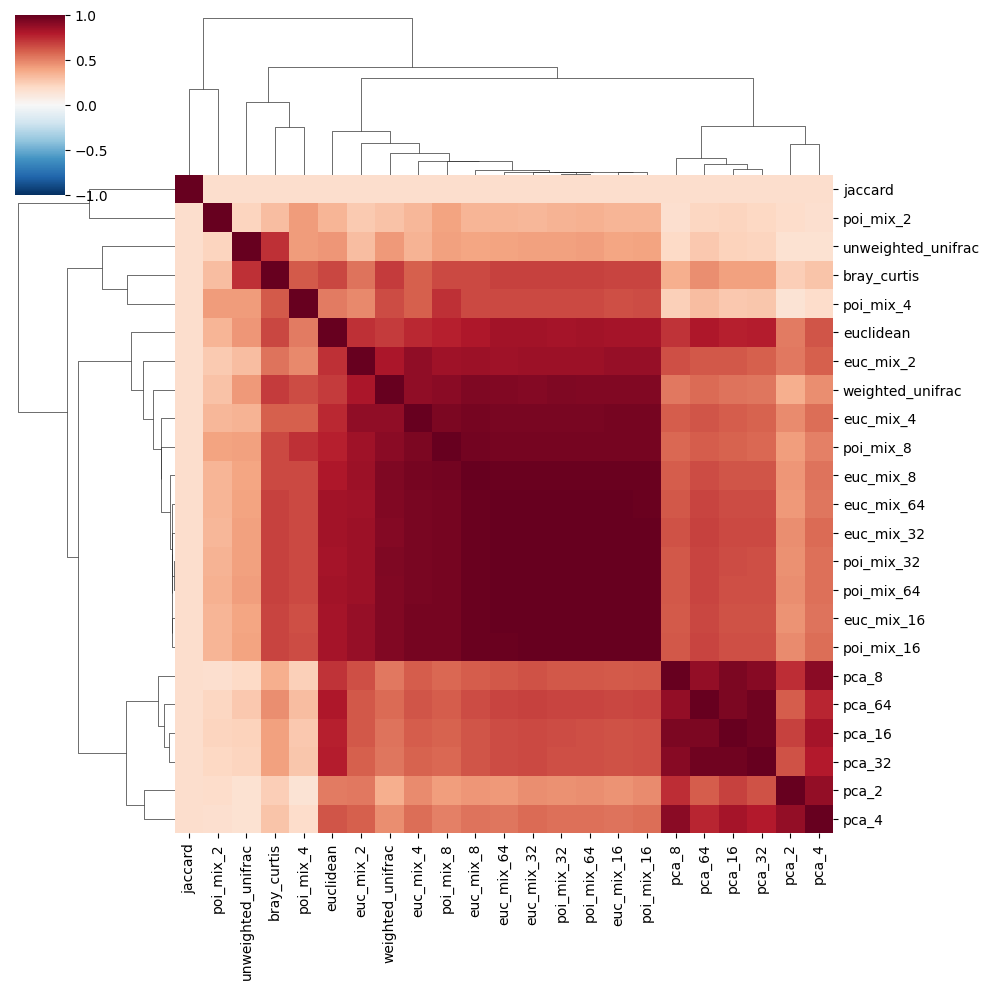

In [10]:
# fig = plt.figure(figsize=(15, 15))
# plt.matshow(
#     corrs.astype(float), cmap="RdBu_r", vmin=-1, vmax=1, fignum=fig.number
# )
# plt.xlabel("Distance metric")
# plt.ylabel("Distance metric")
# plt.xticks(range(len(corrs)), corrs.columns, rotation=90)
# plt.yticks(range(len(corrs)), corrs.columns)
# plt.colorbar()
# plt.show()

# Make a dendrogram + heatmap
from seaborn import clustermap

clustermap(
    corrs.astype(float).dropna(axis=0, how="all").dropna(axis=1, how="all"),
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    figsize=(10, 10),
    xticklabels=True,
    yticklabels=True,
)


In [11]:
# # Head 20 = ~19 minutes for the whole thing
# # Head 50 = ~2 hours
# # Running this on the full table takes a long time, approx. 2 hours

# # OK, that was too slow. Let's do dists separately for each study:
# def get_dists(dist_function, embed=None, head=10, **kwargs):
#     dists = []
#     dir = "/home/phil/mixture_embeddings/data/interim/mlrepo_clean/classification"
#     for subdir in tqdm(os.listdir(dir)):
#         path = os.path.join(dir, subdir, "otus.txt")
#         if os.path.exists(path):
#             otu_table = pd.read_table(path, dtype={0: str})

#             otu_table = otu_table.set_index(
#                 otu_table.columns[0]
#             ).astype(float).T

#             if head is not None:
#                 otu_table = otu_table.head(head)

#             if dist_function == "unifrac":
#                 sample_dists = pdist(
#                     otu_table,
#                     metric=unweighted_unifrac,
#                     otu_ids=otu_table.columns,
#                     tree=tree.shear(otu_table.columns) # Shearing is faster
#                 )
#             else:
#                 sample_dists = pdist(otu_table, metric=dist_function, **kwargs)
#             dists.append(sample_dists)

#     # return np.array([x.data.flatten() for x in dists])
#     return np.concatenate(dists)

# # unifrac_dists = get_dists("unifrac")
# unifrac_dists = get_dists("unifrac", head=HEAD)

# # Takes more than 20 minutes to run on first OTU table...
# np.save(f"data/processed/distances/unifrac_dists_top{HEAD}.npy", unifrac_dists)

# Get unifrac


In [12]:
# Beta diversity
dists = []
dir = "/home/phil/mixture_embeddings/data/interim/mlrepo_clean/classification"
for subdir in tqdm(os.listdir(dir)):
    path = os.path.join(dir, subdir, "otus.txt")
    if os.path.exists(path):
        otu_table = pd.read_table(path, dtype={0: str})

        otu_table = otu_table.set_index(otu_table.columns[0]).astype(float).T

        otu_table = otu_table.head(HEAD)

        sample_dists = beta_diversity(counts=otu_table, metric="braycurtis")
        dists.append(sample_dists)

beta_diversity_dists = np.array([x.data.flatten() for x in dists])

np.save(
    f"data/processed/distances/beta_diversity_dists_top{HEAD}.npy",
    beta_diversity_dists,
)


  0%|          | 0/19 [00:00<?, ?it/s]

NameError: name 'HEAD' is not defined

In [ ]:
for size in [2, 4, 8, 16, 32, 64, 128]:
    # Get embedding distance matrices
    euc_embeddings = pd.read_csv(
        f"/home/phil/DATA/otu_embeddings/embeddings_euclidean_{size}.csv",
        dtype={0: str},
    )
    euc_embeddings = euc_embeddings.set_index(euc_embeddings.columns[0])

    hyp_embeddings = pd.read_csv(
        f"/home/phil/DATA/otu_embeddings/embeddings_hyperbolic_{size}.csv",
        dtype={0: str},
    )
    hyp_embeddings = hyp_embeddings.set_index(hyp_embeddings.columns[0])

    hyp_manifold = Hyperbolic(size, default_coords_type="ball")

    euc_dists = []
    hyp_dists = []
    dir = (
        "/home/phil/mixture_embeddings/data/interim/mlrepo_clean/classification"
    )
    for subdir in tqdm(os.listdir(dir)):
        path = os.path.join(dir, subdir, "otus.txt")
        if os.path.exists(path):
            otu_table = pd.read_table(path, dtype={0: str})

            otu_table = (
                otu_table.set_index(otu_table.columns[0]).astype(float).T
            )

            otu_table = otu_table.head(HEAD)

            otu_table_euc = mixture_embedding(
                otu_table, geometry="euclidean", otu_embeddings=euc_embeddings
            )

            otu_table_hyp = mixture_embedding(
                otu_table, geometry="hyperbolic", otu_embeddings=hyp_embeddings
            )

            euc_dists.append(pdist(sample_dists, metric="euclidean"))
            hyp_dists.append(
                pdist(sample_dists, metric=hyp_manifold._metric.dist)
            )

    euc_dists = np.array([x.flatten() for x in euc_dists])
    hyp_dists = np.array([x.flatten() for x in hyp_dists])

    np.save(
        f"data/processed/distances/euc_dists_top{HEAD}_{size}.npy", euc_dists
    )
    np.save(
        f"data/processed/distances/euc_dists_top{HEAD}_{size}.npy", hyp_dists
    )


  0%|          | 0/19 [00:02<?, ?it/s]


ValueError: A 2-dimensional array must be passed.

In [ ]:
# Load all dists
